## Document-Level Sentiment Analysis with Lexicon and Machine Learning Methods

Demo Dataset from the AIFER Project

In [1]:
import pandas as pd
import geopandas                                                        # geographic data handling
import numpy as np                                                      # data handling
from IPython.display import HTML, display    

# Load AIFER Dataset
aifer = pd.read_csv("../Data/Disaster_responses/ahrtal_tweets.csv", sep="\t")
print(f"AIFER example dataset size: {len(aifer)}")

# show df
demo_cols = aifer[['date','text', 'tweet_lang']]
col_names = {'date': 'Date', 'text': 'Text', 'tweet_lang': 'Language'}
demo_cols = demo_cols.rename(columns=col_names)
demo_cols.sample(3).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

AIFER example dataset size: 11177


,Date,Text,Language
3204,2021-07-11 13:38:35,was ein Tipp: bist du arm dran und kannst es dir nicht leisten iwo besser zu leben na dann hast du zum glück neben einer viel befahrenenstraße weniger Miete + hohes Gesundheitsrisiko🤩🤩😍😍 ... CDU einfach eine schande 🤮,de
10490,2021-07-30 20:58:41,"@castlekitten47 @br_ricke @Esposito544Anna @BeateMermer @Francois7747 @Francois3064 @TomKnutson10 @zaratustra75 @KoesserSandra @carmen_borg60 @berg6bieu @wrigley_derrick @ArmellePrevot @Nikolay37836824 @Heike622 @AlineNathally3 @CaskettOlitz @luana_88_lima @MDegen55 I wish you a Good night Sharon, sleep well and have a magic weekend and happy Saturday. 💛💙 https://t.co/tRG0ARoCwg",en
8144,2021-07-24 07:04:46,@Silke74918142 Guten Tag Silke ☕🙂🌄,de


### Rule-Based/ Lexicon Approaches

Lexicon-based approaches are still used in certain cases, especially when the goal is to perform sentiment analysis **quickly and with a limited amount of computational resources**. In lexicon-based sentiment analysis, words are assigned a sentiment score based on a pre-existing lexicon, such as SentiWordNet or the AFINN lexicon, and the overall sentiment of a text is calculated by summing the sentiment scores of the individual words.

Lexicon-based approaches have several advantages: 
- Ease of use
- Speed
- Interpretability

But there are downsides:
- Difficulties with sarcasm, negation, sentiment of words in context


<img src="https://t-redactyl.io/figure/Vader_1.jpg" align="right" width="20%">

**Example lexicon**: VADER (Valence Aware Dictionary and sEntiment Reasoner) <br> <br>
VADER is specifically attuned to sentiments expressed in social media. It uses a combination of sentiment-related words and emojis, along with some simple heuristics (punctuation, capitalisation, degree modifiers, conjuctions), to assign a sentiment score (positive, negative, or neutral) to a given piece of text. It's output sentiment score is a numeric score between -1 and +1. The word sentiment scores range from -4 to 4 (neg to pos). <br> <br>
Example of some words in the lexicon and their scores: <br> 

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    # VADER
sa = SentimentIntensityAnalyzer()                                       # Create the variable sa to hold the VADER lexicon object 

import pandas as pd
import geopandas                                                        # geographic data handling
import numpy as np                                                      # data handling
from IPython.display import HTML, display                               # interactive notebook features

import matplotlib.pyplot as plt                                         # data visualisation and graphical plotting
%matplotlib inline
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

import plpygis                                                         # a converter to and from the PostGIS geometry types, WKB, GeoJSON and Shapely formats
from plpygis import Geometry
import descartes                                                       # an integration for Shapely geometry objects with Matplotlib

import folium                                                          # interactive mapping capabilities
import mapclassify 

from shapely.geometry import Point, Polygon, shape                     # creating geospatial data
from shapely import wkb, wkt                                           # creating and parsing geospatial data
import shapely


import pysal
from pysal.lib import weights
import seaborn as sns
sns.set_style("darkgrid")


D:\Users\Christina\Programmes\envs\GRACE_GPU\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


In [3]:
lex = pd.Series(sa.lexicon).to_frame()
lex = lex.rename(columns={0: "Sentiment Score"})
lex[1010:1020]

,Sentiment Score
beautiful,2.9
beautifuler,2.1
beautifulest,2.6
beautifully,2.7
beautifulness,2.6
beautify,2.3
beautifying,2.3
beauts,1.7
beauty,2.8
belittle,-1.9


A sample of how the VADER lexicon would classify the AIFER dataset (english tweets only):

In [4]:
# english only
aifer_en = aifer[aifer['tweet_lang']== 'en']
# print(len(aifer_en))

scores = {}
listscores = []

for tweet in aifer_en['text']:
    scores[sa.polarity_scores(tweet)['compound'] ] = str(tweet)
    listscores.append(sa.polarity_scores(tweet)['compound'])

aifer_en_copy = aifer_en.copy()
aifer_en_copy['sentiment'] = listscores

# show df
aifer_en_copy_demo = aifer_en_copy[['sentiment','text']]
pd.options.display.float_format = '{:,.2f}'.format
aifer_en_copy_demo.sample(4).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])


,sentiment,text
10089,0.971600,@Mini_okdoksmok @MariahCarey That has been THE year 🥰🥰🥰
3646,0.980600,@MDegen55 Good morning my friend Gus. Enjoy the Tuesday. 😊😊Have a beautiful Sunshine Day. 🌞🍀🌞🌞🍨🍨🍵🍵 https://t.co/40QEmvkC6Y
4045,0.361200,"@jsneufeld @euro2021Athens Thank you, Janis"
4659,-0.773400,"My thoughts and prayers go out to the families and their friends who has lost somebody in this horrible flood 😢😢😢🕊 - and prayers for those, who are missing , they ll be back safe soon 🖤❤️💛🇩🇪"


### Machine Learning Approach: Naive Bayes

Naive Bayes is a probabilistic algorithm (based on Bayes' theorem). It uses the probability of words or terms appearing in documents of different categories to determine the likelihood that a new document belongs to each category. It involves two basic steps: 
>
>**Training**: The algorithm learns the probability of words or terms appearing in each category. This is simply done by counting the number of occurrences of each word or term in the training corpus for each category and then computing the probability of each word or term given the category. This results in a set of word probabilities for each category.
>
>**Classification**: The algorithm uses the probabilities learned in the training step to classify new documents. For a new document, the algorithm calculates the likelihood of the document being in each category based on the probabilities of its words or terms. The category with the highest likelihood is chosen as the classification for the document.
>

The "naive" aspect of Naive Bayes comes from the assumption that the occurrences of words or terms in a document are independent of one another, which is not always true(!).




In [5]:
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET           # for parsing XML file
import urllib.request

# for preprocessing 
import re
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Helper Functions

Helper Functions:
- `process tweet(tweet)`: performs stopword removal, RT, hyperlink, punctuation, and # removals, stemming, and tokenisation. Returns a list of tokenised words.
- `count_sents(result, texts, ys)`: Iterates through training dataset to create a dict with (word, sentimentlabel) = count to indicate how often a given word is associated with positive or negative sentiments.
- `lookup(freqs, word, label)`: checks frequencies of a (word, label) pair in the training data.
- `addgeom(in_df)`: Reads the 'geom' column of the input df, turns it into a shapely Geometry type and generates a new geodataframe (geopandas) which can be used to plot tweets on a map. Returns new geo-df.
- `importdata()`: Allows the user to either upload their own CSV file or resorts to the default monkeypox dataset. 
- `createplot(dataframe, title)`: Generates a histogram plot showing the sentiment scores that are added to the dataset.
- `split_test_train(dataframe)`: function to split up an input dataframe into 80% training and 20% testing data. Both training and testing datasets are split into x (text) and y (labels). 

In [6]:
def process_tweet(tweet):
    '''
    Input:
        text/tweet: a string containing a tweet or text
    Output:
        text_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    #tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

    # create dictionary keeping track of how often a word is associated with a 
# pos or neg sentiment
# result(word, label) = count

def count_sents(result, texts, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    # iterate through rows
    for y, text in zip(ys, texts):
      # iterate through each preprocessed word in text
      for word in process_tweet(text):
        # define the key, which is the word and label tuple
        pair = (word, y)
        
        # if the key exists in the dictionary, increment the count
        if pair in result:
            result[pair] += 1

        # else, if the key is new, add it to the dictionary and set the count to 1
        else:
            result[pair] = 1

    return result

def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

# turn nurmal dataframe with 'geom' column into a geodataframe

def addgeom(in_df):
  '''
  Input:
    in_df: a dataframe with a 'geom' column to be converted into a shapely 
    Geometry column
  Output: 
    a geopandas dataframe with a designated geometry column which can be mapped
  '''
  
  # initiate new geom list
  new_geom = []

  # access 'geom' column in input df and convert into geopandas geometry
  for item in in_df['geom']:
      new_geom.append(Geometry(item).shapely)

  # add as new column to input df
  in_df["geometry"] = new_geom

  # create geopandas GeoDataFrame
  df_geo = geopandas.GeoDataFrame(in_df, crs="EPSG:4326")
  s = geopandas.GeoSeries(df_geo['geometry'])
  df_geo['geom'] = df_geo['geometry']
  df_geo['geometry'] = df_geo['geom'].to_crs('epsg:3785').centroid.to_crs(df_geo.crs)

  return df_geo

# either upload own dataset or use one of the defaults
def importdata():
  # get user input
  own_upload = input("Do you want to upload your own .CSV dataset?\nIf you choose to upload your own, make sure it has a 'text' and a 'geom' column.\n(y /n): ")
  
  if own_upload == 'y' or own_upload == 'Y' or own_upload == 'yes':
    uploaded = files.upload()
    dataset = pd.read_csv(uploaded)
  else:
    # Load dataset (also from mounted google drive)
    dataset = pd.read_csv('/content/drive/MyDrive/Msc AGI/Master/notebooks/100k_monkeypox.csv')
  return dataset

def createplot(dataframe, title):
  legend = ['Sentiments'] 
  
  # create histogram
  fig, ax1 = plt.subplots(1, figsize =(20, 7),  tight_layout = True) 
    
  # Remove axes spines  
  for s in ['top', 'bottom', 'left', 'right']:  
      ax1.spines[s].set_visible(False)  
      
  # Remove x, y ticks 
  ax1.xaxis.set_ticks_position('none')  
  ax1.yaxis.set_ticks_position('none')  
      
  # Add padding between axes and labels  
  ax1.xaxis.set_tick_params(pad = 5)  
  ax1.yaxis.set_tick_params(pad = 10)  
    
  # Add x, y gridlines  
  ax1.grid(visible = True, color ='grey',  linestyle ='-.', linewidth = 0.5,  alpha = 0.6)  

  cm = plt.cm.get_cmap('RdYlGn')
  Y,X = np.histogram(dataframe['sentiment_score'], 28)
  x_span = X.max()-X.min()
  C = [cm(((x-X.min())/x_span)) for x in X]

  # Creating histogram 
  plt.subplot(1,2,1)
  plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])

  # Adding extra features     
  plt.xlabel("Sentiment Score") 
  plt.ylabel("# of Tweets") 
  plt.legend(legend) 
  plt.title(title) 

# split df into test and training data 
def split_test_train(dataframe, name):
  '''
  Input: 
    dataframe: a dataframe with a column 'sentiment' with 0s and 1s 
  Output:
    train_x: 80% of the data, both pos and neg texts
    test_x: 20% of the data, both pos and neg texts
    train_y: 80% of the data, corresponding labels 
    test_y: 20% of the data, corresponding labels
  '''

  # split positive and negative texts
  pos = dataframe[dataframe['sentiment'] == 1]
  neg = dataframe[dataframe['sentiment'] == 0]

  # print lengths
  #print(f'Positive Texts: {len(pos)}')
  #print(f'Negative Texts: {len(neg)}')

  # Plot the data
  labels = ['Positive Texts', 'Negative Texts']
  data = [len(pos), len(neg)]

  x_axis = ['Positive','Negative']
  y_axis = [len(pos), len(neg)]

  plt.figure(figsize=(6, 4))

  # set the custom colors
  colors = ['#73E87F' ,'#F24E4E']

  # plot the bar chart
  plt.bar(x_axis, y_axis, color=colors)

  # Add title and labels
  plt.title(f"Sentiment Distribution in the {name} Dataset")
  plt.xlabel("Sentiment")
  plt.ylabel("Count")

  plt.show()

  # split into training and testing datasets: 80% to 20%
  split_pos_at_80_percent = round(len(pos) * 0.8)
  split_neg_at_80_percent = round(len(neg) * 0.8)

  train_pos = pos[: split_pos_at_80_percent]
  test_pos = pos[split_pos_at_80_percent :]
  train_neg = neg[: split_neg_at_80_percent]
  test_neg = neg[split_neg_at_80_percent :]

  # train_pos.head()

  train_x = list(train_pos["text"]) + list(train_neg["text"])
  test_x = list(test_pos['text']) + list(test_neg['text'])
  train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
  test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

  return train_x, test_x, train_y, test_y


#### Naive Bayes Functions

Includes 3 functions:
- `train_naive_bayes(freqs, train_x, train_y)`
- `naive_bayes_predict(tweet, logprior, loglikelihood)` 
- `test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict)`

<br>

**Training Steps**
- Identify the number of classes (=2).
- Create a probability for each class.
$P(D_{pos})$ is the probability that given text/document is positive.
$P(D_{neg})$ is the probability that the given text/document is negative.

$$P(D_{pos}) = \frac{D_{pos}}{D}\$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\$$

Where $D$ is the total number of documents (or tweets), $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.The probabilites are stored in a dict. 

<br>

**Prior and Logprior**

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$
\text{logprior} = \log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = \log \left( \frac{D_{pos}}{D_{neg}} \right)
$$


In [7]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set(pair[0] for pair in freqs.keys())
    V = len(vocab)    

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]
    
    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = np.sum(train_y)

    # Calculate D_neg, the number of negative documents
    D_neg = D - D_pos

    # Calculate logprior
    logprior = np.math.log(D_pos) -  np.math.log(D_neg)
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = ((freq_pos + 1) / (N_pos + V))
        p_w_neg = ((freq_neg + 1) / (N_neg + V))

        # calculate the log likelihood of the word
        loglikelihood[word] = np.math.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood

In [8]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood.get(word)

    return p

In [9]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y 
    error = np.mean(np.absolute(y_hats - test_y))

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    return accuracy

<br>

Two datasets for training the Naive Bayes classifiers:
<br>
SemEval 2014 (Task 4)

In [10]:
# load from url
url = 'https://git.sbg.ac.at/s1080384/sentimentanalysis/-/raw/main/data/Restaurants_Train_v2.xml'
document = urllib.request.urlopen(url).read()
root = ET.fromstring(document)

# show example text from dataset (semeval 2014)
# root[0][0].text

# create dataframe from xml file
data = []
for sentence in root.findall('sentence'):
    text = sentence.find('text').text
    aspectCategories = sentence.find('aspectCategories')
    for aspectCategory in aspectCategories.findall('aspectCategory'):
        category = aspectCategory.get('category')
        polarity = aspectCategory.get('polarity')
        data.append((text, category, polarity))

semeval = pd.DataFrame(data,columns=['text','category','polarity'])

# add column with 0s and 1s in place of textual sentiment values
semeval['sentiment'] = np.where(semeval['polarity']== 'positive', 1, np.where(semeval['polarity']== 'negative',0, -1))

# preview Semeval
semeval.head(5)

,text,category,polarity,sentiment
0,But the staff was so horrible to us.,service,negative,0
1,"To be completely fair, the only redeeming fact...",food,positive,1
2,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative,0
3,"The food is uniformly exceptional, with a very...",food,positive,1
4,Where Gabriela personaly greets you and recomm...,service,positive,1


... and the Twemlab Goldstandard

In [11]:
# Load TwEmLab Goldstandard
url1 = 'https://git.sbg.ac.at/s1080384/sentimentanalysis/-/raw/main/data/TWEMlab%20Test%20Dataset/goldstandard20170719.xml'
document1 = urllib.request.urlopen(url1).read()
root1 = ET.fromstring(document1)

# check contents
#root1[0][1].text

# create dataframe from xml file
data1 = []
for tweet in root1.findall('Tweet'):
    id = tweet.find('ID').text
    label = tweet.find('Label').text
    data1.append((id, label))

df1=pd.DataFrame(data1,columns=['id','label'])

# Load TwEmLab Boston Tweets
url2 = 'https://git.sbg.ac.at/s1080384/sentimentanalysis/-/raw/main/data/TWEMlab%20Test%20Dataset/boston_gs.xml'
document2 = urllib.request.urlopen(url2).read()
root2 = ET.fromstring(document2)

# check contents
# root2[0][1].text

# create dataframe from xml file
data2 = []
for tweet in root2.findall('Tweet'):
    id = tweet.find('ID').text
    text = tweet.find('text').text
    goldstandard = tweet.attrib.get("goldstandard")
    data2.append((id, text, goldstandard))

df2=pd.DataFrame(data2,columns=['id','text', 'goldstandard'])

# merge the two separate dataframes based on id columns
merge = pd.merge(df1, df2, on='id')

# keep only the tweets that are part of the goldstandard
twemlab = merge[merge['goldstandard'] == 'yes']
# print(f'Number of tweets in goldstandard: {len(twemlab)}')

# assign sentiment label (0, 1) based on emotion
# -1 of NONE, will be excluded in later analysis
twemlab['sentiment'] = np.where((twemlab['label'] == 'beauty') | (twemlab['label'] == 'happiness'), 1, 
                                 np.where(twemlab['label'] == 'none', -1, 0))

In [12]:
# check dataset
twemlab[5:10]

,id,label,text,goldstandard,sentiment
5,200000000000000006,sadness,"The unnamed woman, in her 30s, had been on the...",yes,0
6,200000000000000007,anger/disgust,Attempt theft from Motor Vehicle - Rookery Par...,yes,0
7,200000000000000008,beauty,Heather and webs... #heather #cobwebs #nature ...,yes,1
8,200000000000000009,sadness,"The unnamed woman, in her 30s, had been on the...",yes,0
9,200000000000000010,sadness,Birmingham: Lianne Harris - mini Pype Hayes Pa...,yes,0


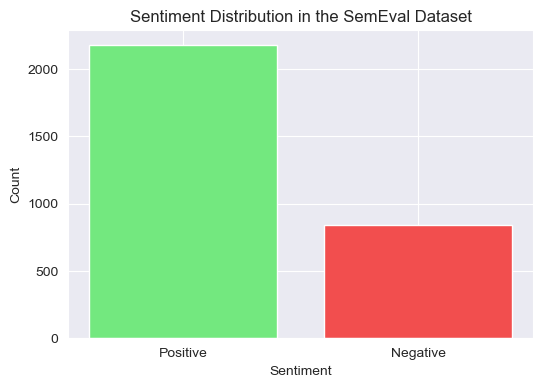

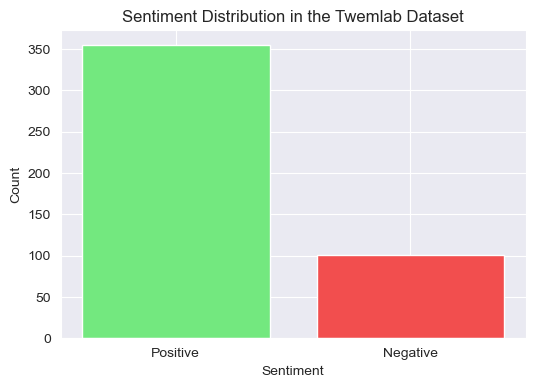

In [13]:
# Split both datasets into training and testing subsets and show overall sentiment distribution
train_x, test_x, train_y, test_y = split_test_train(semeval, "SemEval")
train_x_tw, test_x_tw, train_y_tw, test_y_tw = split_test_train(twemlab, "Twemlab")


In [14]:
# TRAIN SEMEVAL NAIVE BAYES
# Build a freqs dictionary to count how often a given word is associated with a
# positive or negative label
freqs = count_sents({}, train_x, train_y)

# Check how the freqs dict turned out
for i in range(10):
  checking = list(freqs.keys())[i] 
  print(f'key: {checking}, count: {freqs[checking]}')

# call the train function for naive bayes model to get logprior and loglikelihood
#  
# logprior = the baseline likelihood that a given text is positive or negative 
#     simply based on the proportions of positive and negative texts (i.e. a 
#     logprior around 0 indicates a very balanced dataset)
#
# loglikelihood = a sum of the logarithms of the conditional probability ratio
#     of all unique words in the corpus

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

# TRAIN TWEMLAB NAIVE BAYES
# Build a freqs dictionary to count how often a given word is associated with a
# positive or negative label
freqs1 = count_sents({}, train_x_tw, train_y_tw)

# Check how the freqs dict turned out
for i in range(10):
  checking1 = list(freqs1.keys())[i] 
  print(f'key: {checking1}, count: {freqs1[checking1]}')

logprior1, loglikelihood1 = train_naive_bayes(freqs1, train_x_tw, train_y_tw)


key: ('complet', 1.0), count: 6
key: ('fair', 1.0), count: 7
key: ('redeem', 1.0), count: 1
key: ('factor', 1.0), count: 1
key: ('food', 1.0), count: 378
key: ('averag', 1.0), count: 6
key: ('make', 1.0), count: 37
key: ('defici', 1.0), count: 1
key: ('teodora', 1.0), count: 1
key: ('uniformli', 1.0), count: 1
key: ('say', 1.0), count: 1
key: ('summer', 1.0), count: 6
key: ('beauti', 1.0), count: 21
key: ('run', 1.0), count: 15
key: ('edinburgh', 1.0), count: 1
key: ('last', 1.0), count: 9
key: ('friday', 1.0), count: 2
key: ('sutton', 1.0), count: 85
key: ('park', 1.0), count: 230
key: ('saturday', 1.0), count: 5


In [15]:
# Experiment with your own "tweet", e.g. "looks great" or "having a bad day"
# Uncomment lines below

my_tweet = input('Test both naive bayes on own text! Enter something here:')
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
p1 = naive_bayes_predict(my_tweet, logprior1, loglikelihood1)

print('The output from the SemEval trained Naive Bayes model is:', p)
print('The output from the Twemlab trained Naive Bayes model is:', p1)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

1: @janlisiecki Do you know vegan ducklings, even bluish? https://t.co/LUdKqOydyD

2: @debbslovesnate @br_ricke @cheezysox @Firefly7113 @carmen_borg60 @homenor56 @zaratustra75 @karo8710 @anysogo @Esposito544Anna @stellapocecilia @bancroft_lotty @koshaid1 @Kranich65 @castlekitten47 @shannon_hausen @HartZsuzsanna @CaskettOlitz @caskettuniverse @NathanFillion @NFillionOnline @germannateclub @castle_all @MononenMinna @Star_Medd @pocs80 @CheerfulChemist @castle_alwayys @MDegen55 Have a great weekend Debbie. Enjoy the afternoon. 🍵🌞💞 https://t.co/LkjCcJTIou

3: Explored Cochem Castle and the Mosel River Valley yesterday. https://t.co/1wkfMW7aR1

4: @dpd_de In March I received late a parcel & I had to throw part of its content away bc it was rotten. Today I had to receive another parcel & the delivery man didn’t follow my instructions, I will get it 3 days late. I’ll have to throw away part of the content AGAIN. No words…

5: @MDegen55 Good morning @LawrenCali @leingh @moa_roos @cibir68 @elena

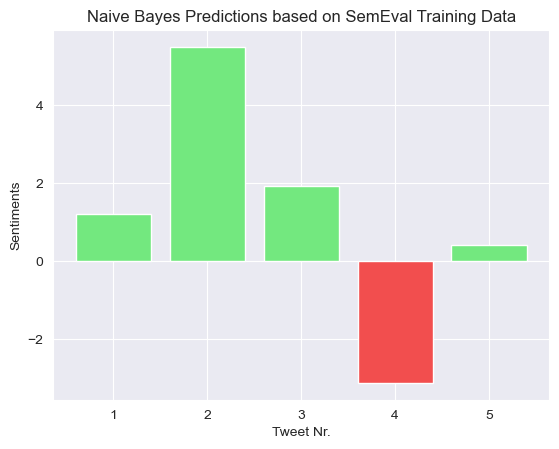

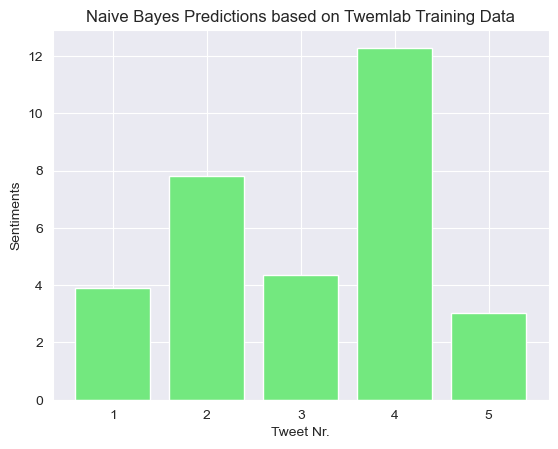

In [21]:
# for demo purposes, sample 5 english tweets
sample_tweets = aifer_en.sample(5)

# empty lists
p_semeval = []
p_twemlab = []
tweets = []
numbers = list(range(1, 6))
string_numbers = list(map(str, numbers))

# get prediction from both NB classifiers for each tweet
for index, row in sample_tweets.iterrows():
    tweets.append(row['text'])
    p_semeval.append(naive_bayes_predict(row['text'], logprior, loglikelihood))
    p_twemlab.append(naive_bayes_predict(row['text'], logprior1, loglikelihood1))

# function to plot results visually
def plot_sentiments(numbers, sentiments, name):
    """
    Plots a bar plot of the words and their sentiments.
    
    Parameters:
        words (list of str): A list of words.
        sentiments (list of float): A list of sentiment scores between -1 and 1 for each word.
        name (str): title of dataset
    Returns:
        None
    """
    colors = ['#73E87F' if score > 0 else '#F24E4E' for score in sentiments]
    fig, ax = plt.subplots()
    ax.bar(numbers, sentiments, color=colors)
    ax.set_xlabel("Tweet Nr.")
    ax.set_ylabel("Sentiments")
    ax.set_title(f"Naive Bayes Predictions based on {name} Training Data")
    plt.show()

for i in range(len(tweets)):
    print(f"{numbers[i]}: {tweets[i]}\n")

# input list of tweets, the according sentiment scores, and the name of the dataset for NB training
plot_sentiments(numbers, p_semeval, "SemEval")
plot_sentiments(numbers, p_twemlab, "Twemlab")


In [23]:
print("Naive Bayes accuracy when trained on SemEval 2014 = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

print("Naive Bayes accuracy when trained on Twemlab = %0.4f" %
      (test_naive_bayes(test_x_tw, test_y_tw, logprior1, loglikelihood1)))

Naive Bayes accuracy when trained on SemEval 2014 = 0.7947
Naive Bayes accuracy when trained on Twemlab = 0.9121


### Machine Learning Approach: Support Vector Machine 

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_svm_margin_thumb.png" align="right"> 

Using readily available libraries like sklearn, an SVM classifier (in this case SVC (Support Vector Classification)) can be trained for binary classification problems like pos-neg sentiment classification. The SVC classifier predicts the class label of a given sample based on the feature set. It solves the optimization problem to find a hyperplane that maximally separates the positive and negative class samples in the feature space. The optimization problem is solved using the maximum margin principle, where the margin is the distance between the hyperplane and the closest samples from each class, called support vectors. The SVC classifier is a useful tool for performing binary classification problems, particularly when the number of features is high, and the data is not linearly separable.





In [8]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

# semeval binary sentimetns pos-neg
semeval_binary = semeval[(semeval['sentiment'] == 1) | (semeval['sentiment'] == 0)]

# Convert the text data into numerical features using CountVectorizer
vectorizer = CountVectorizer()

# Preprocess and split the data
X = vectorizer.fit_transform(semeval_binary["text"])
y = semeval_binary['sentiment'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = SVC()
clf.fit(X_train, y_train)

# Test the classifier
y_pred = clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy.round(3))
print('Precision: ', precision.round(3))
print('Recall: ', recall.round(3))
print('F1-score: ', f1.round(3))

Accuracy:  0.762
Precision:  0.772
Recall:  0.939
F1-score:  0.847


Using the trained (on SemEval 2014) SVM classifier to classify the AIFER english dataset. Here is a sample of the classification:

In [29]:
# Test the classifier
X_new = vectorizer.transform(aifer_en["text"])
y_pred = clf.predict(X_new)
aifer_en['sentiment_svm'] = y_pred


C:\Users\Christina\AppData\Local\Temp\ipykernel_13860\2473405338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aifer_en['sentiment_svm'] = y_pred


In [50]:
aifer_demo = aifer_en[['sentiment_svm', 'text']]
col_names = {'text': 'Text', 'sentiment_svm': 'SVM Sentiment'}
aifer_demo = aifer_demo.rename(columns=col_names)
aifer_demo.sample(5).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

,SVM Sentiment,Text
10550,1,Explored Cochem Castle and the Mosel River Valley yesterday. https://t.co/1wkfMW7aR1
1840,1,@MDegen55 Happy Wednesday Debbie. 💛💙💚 https://t.co/s71wEY6LZz
510,1,@koshaid1 @pocs80 @AnetteRuff1 @piaroos1 @moa_roos @Jenny_S3005 @nlopes952 @MononenMinna @sadino22 @blovencik @HartZsuzsanna @FabischKerstin @stellapocecilia @MontrucchiPaola @Chrissychatt @Kranich65 @iges2u @frmirielis @andibeth012 @christeld23 @manfred_degen @60Ritschi @MDegen55 Good evening Gus. https://t.co/rg4ckBWmiT
94,0,"@KalengaKamwendo Bro till this day, I am mad my dad asked me to focus on school & not Sport.😒 I think we need better systems to identify & develop talent."
852,1,"you don’t always need a plan - sometimes you just need to breathe, trust, let go, and see what happens. ☆ SHOOTING. SCHLOSS KOBLENZ photo. @le_fotografie_cgn #danielagviolin #danielagcom #violin #violinist #geige #violinshoot #fotoshoot #schlosskoblenz #koblenz https://t.co/EpbL1113LK"


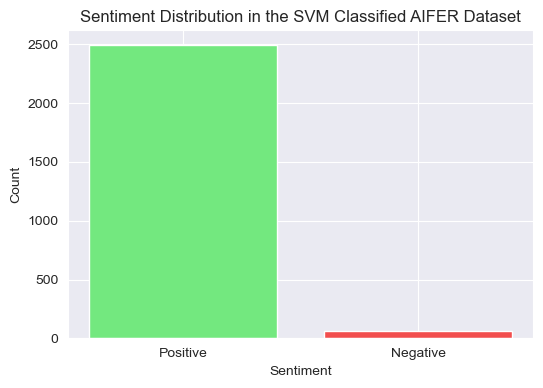

In [51]:
# split positive and negative texts
pos = aifer_en[aifer_en['sentiment_svm'] == 1]
neg = aifer_en[aifer_en['sentiment_svm'] == 0]

# Plot the data
labels = ['Positive Tweets', 'Negative Tweets']
data = [len(pos), len(neg)]

x_axis = ['Positive','Negative']
y_axis = [len(pos), len(neg)]

plt.figure(figsize=(6, 4))

# set the custom colors
colors = ['#73E87F' ,'#F24E4E']

# plot the bar chart
plt.bar(x_axis, y_axis, color=colors)

# Add title and labels
plt.title(f"Sentiment Distribution in the SVM Classified AIFER Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.show()

In recent years, the use of lexicon-based methods and traditional machine learning models for sentiment analysis has **decreased in popularity**. This shift has been largely driven by the **emergence of deep learning models**, which have shown impressive results on NLP tasks such as sentiment classification. With the availability of vast amounts of text data, deep learning models such as transformers have been able to capture more complex patterns and relationships within the data, leading to improved performance compared to lexicon-based and machine learning models. As a result, deep learning methods are now seen as the state-of-the-art approach for sentiment analysis and other NLP tasks.